In [36]:
import treecorr

from random import *
import math
import numpy as np
import astropy.table
from matplotlib import pyplot as plt
from astroML.datasets import fetch_sdss_specgals

import pickle

In [37]:
def randomcorr(dataset, cat):
    
    ra_range = max(cat.ra) - min(cat.ra)
    dec_range = max(cat.dec) - min(cat.dec)
    ra_min = min(cat.ra)
    dec_min = min(cat.dec)
    
    rand_ra = []
    rand_dec = []

    min_cth = np.min(np.sin(cat.dec))
    max_cth = np.max(np.sin(cat.dec))
    rand_dec = np.arcsin(min_cth+(max_cth-min_cth)*np.random.random(size=len(dataset))) 

    for i in range(len(dataset)):
        u = random()
        rand_ra.append((2*math.pi*u)*(ra_range/(2*math.pi)) + ra_min)
        
    rr = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg')
    catrand = treecorr.Catalog(ra = rand_ra, dec = rand_dec, ra_units='rad', dec_units='rad')
    
    return catrand;

In [46]:
def plotcorr(dataset1, dataset2, bin_centers, corr, corr_stdev, error):
    labels = ['$u-r > 2.22$\n$N=%i$' % len(dataset1),
          '$u-r < 2.22$\n$N=%i$' % len(dataset2)]
    
    fig = plt.figure(figsize=(5, 2.5))
    fig.subplots_adjust(bottom=0.2, top=0.9,
                        left=0.13, right=0.95)

    for i in range(2):
        ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

        ax.set_ylim([10**(-2),10])
        ax.set_yscale('log')

        ax.set_xlim([10**(-2),10])
        ax.set_xscale('log')
    

        if error:
            ax.errorbar(math.e**bin_centers[i], corr[i][0], corr_stdev[i], fmt='.k', ecolor='gray', lw=1)
        else:
            plt.scatter(math.e**(bin_centers[i]), corr[i][0])
        
        t = np.array([0.01, 10])
        ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

        ax.text(0.95, 0.95, labels[i],
                ha='right', va='top', transform=ax.transAxes)
        ax.set_xlabel(r'$\theta\ (deg)$')
        if i == 0:
            ax.set_ylabel(r'$\hat{w}(\theta)$')
    
    with open('treecorr_bins0_2', 'wb') as filehandle:
            pickle.dump(bin_centers[0], filehandle)
            
    with open('treecorr_bins1_2', 'wb') as filehandle:
            pickle.dump(bin_centers[1], filehandle)
            
    with open('treecorr_corr0_2', 'wb') as filehandle:
            pickle.dump(corr[0][0], filehandle)
    
    with open('treecorr_corr1_2', 'wb') as filehandle:
            pickle.dump(corr[1][0], filehandle)
            

In [50]:
def calccorr(dataset):
    
    nn = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg',var_method='jackknife') 
    cat = treecorr.Catalog(ra = dataset['ra'], dec = dataset['dec'], ra_units='deg', dec_units='deg',npatch = 100)
    nn.process(cat)

    catrand = randomcorr(dataset, cat)
    rr = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6, sep_units = 'deg',var_method='jackknife')
    rr.process(catrand)
    
    dr = treecorr.NNCorrelation(nbins = 16, min_sep = 1/60, max_sep = 6,sep_units = 'deg',var_method='jackknife')
    dr.process(cat, catrand)

    corr = nn.calculateXi(rr, dr)
    bin_centers = nn.meanlogr
    cov = nn.estimate_cov('jackknife')
    
    return [corr, bin_centers, cov]

In [43]:
def producecorrplots(error = False):
    data = getdata()[0]
    data_red = getdata()[1]
    data_blue = getdata()[2]

    calc_red = calccorr(data_red)
    calc_blue = calccorr(data_blue)

    corr = [calc_red[0], calc_blue[0]]
    bin_centers = [calc_red[1], calc_blue[1]]

    corr_stdev_red = [math.sqrt(k) for k in corr[0][1]]
    corr_stdev_blue = [math.sqrt(k) for k in corr[1][1]]
    corr_stdev = [corr_stdev_red, corr_stdev_blue]
    
    plotcorr(data_red, data_blue, bin_centers, corr, corr_stdev, error)

In [41]:
def getdata():
    data = fetch_sdss_specgals()
    m_max = 17.7
    # redshift and magnitude cuts
    data = data[data['z'] > 0.08]
    data = data[data['z'] < 0.12]
    data = data[data['petroMag_r'] < m_max]
    # RA/DEC cuts
    RAmin, RAmax = 140, 220 
    DECmin, DECmax = 5, 45
    data = data[data['ra'] < RAmax] 
    data = data[data['ra'] > RAmin] 
    data = data[data['dec'] < DECmax] 
    data = data[data['dec'] > DECmin]
    ur = data['modelMag_u'] - data['modelMag_r'] 
    flag_red = (ur > 2.22)
    flag_blue = ~flag_red
    data_red = data[flag_red] 
    data_blue = data[flag_blue]
    
    return [data, data_red, data_blue]

[[0.09273247 0.0584855  0.0422014  0.04095268 0.03686445 0.02831012
  0.02388348 0.01790932 0.01653265 0.01512138 0.01546702 0.0151266
  0.01608973 0.01555058 0.01313603 0.00947316]
 [0.0584855  0.07179534 0.04011868 0.04200307 0.03561932 0.0281319
  0.02255624 0.01757008 0.01614527 0.01480516 0.01486506 0.01469015
  0.01571036 0.01560714 0.01389461 0.01081023]
 [0.0422014  0.04011868 0.03595925 0.0298956  0.02625614 0.02013275
  0.01753062 0.01350744 0.01239731 0.01131639 0.01132938 0.01107679
  0.01144804 0.0111284  0.00990186 0.00757607]
 [0.04095268 0.04200307 0.0298956  0.03363504 0.02694034 0.0212065
  0.01826447 0.01440888 0.01336063 0.01188022 0.01185722 0.01156707
  0.01229011 0.01205186 0.01063684 0.00829739]
 [0.03686445 0.03561932 0.02625614 0.02694034 0.02508492 0.01889622
  0.01612802 0.01290851 0.01187538 0.01064331 0.01059381 0.01032377
  0.01078675 0.01044725 0.00908155 0.00681304]
 [0.02831012 0.0281319  0.02013275 0.0212065  0.01889622 0.01568394
  0.01341234 0.01061

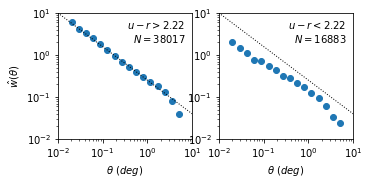

In [51]:
producecorrplots()